# Using external state representations with BGLS

Here we demonstrate creating a simple state vector type representation, and how to interface it with BGLS through bitstring probability and gate application functions.

In [1]:
import numpy as np
import bgls
import cirq
import matplotlib.pyplot as plt
import itertools
from typing import List

In [2]:
def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return itertools.chain.from_iterable(itertools.combinations(s, r) for r in range(len(s)+1))

def flip_bit(index, bit_to_flip):
    return index ^ (1 << bit_to_flip)

In [5]:
class StateVecRep:
    """Simple complex state vector representation, 2^#qubits size. Starts in the 0...0 state"""
    def __init__(self, num_qubits:int):
        self.num_qubits = num_qubits
        self.vector = np.zeros(2**num_qubits, dtype=complex)
        self.vector[0] = 1. + 0.j
    
    def copy(self):
        # returns a copy of this state, leaving this one unaltered
        new_state = StateVecRep(self.num_qubits)
        new_state.vector = np.copy(self.vector)
        return new_state


def bitstring_probability(state:StateVecRep, bitstring:str):
    rev_bitstr = bitstring[::-1]
    return np.abs(state.vector[int(rev_bitstr,2)])**2

# helper functions
def apply_gate_to_subspace(gate:np.ndarray, state:np.ndarray, indices:np.ndarray):
    # gate: 2^qx2^q numpy matrix, complex valued
    # state: 2^n numpy array, complex valued
    # indices: numpy array, integer valued, should be 2^q items in list
    assert(indices.size == gate.shape[1])
    subspace = state[indices]
    output = gate.dot(subspace)
    state[indices] = output

def apply_gate(gate:np.ndarray, target_bits:List[int], state:np.ndarray):
    # target_bits is a list of q qubit indices the q-bit gate is applied to
    n = state.size # for n qubits this is 2**n
    q = len(target_bits)
    # flag whether we have worked on a given index already
    already_applied = np.zeros(n, dtype=int)
    for l in range(n):
        if already_applied[l]:
            continue
        subspace_indices = [l]
        for combo in powerset(target_bits):
            # eg [i0], [i1], [i0, i1], etc., one of these lists
            if combo: # ignore the empty element
                tempidx = l
                for bit in combo:
                    tempidx = flip_bit(tempidx, bit)
                subspace_indices.append(tempidx)

        apply_gate_to_subspace(gate, state, np.asarray(subspace_indices))
        for idx in subspace_indices:
            already_applied[idx] = 1


def apply_cirq_gate(op: cirq.Operation, state:StateVecRep):
    gate_matrix = cirq.unitary(op.gate)
    gate_indices = []
    for qubit in op.qubits:
        # x for a line qubit is its number eg LineQubit(3) has 3 qubits, x returns either 0, 1, 2
        gate_indices.append(qubit.x)

    apply_gate(gate_matrix, gate_indices, state.vector)


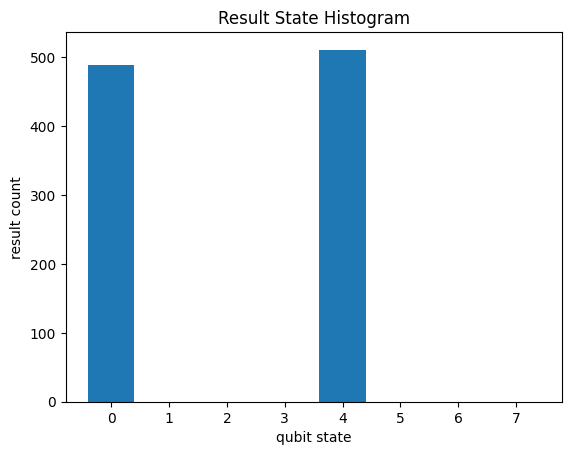

In [7]:
qubits = cirq.LineQubit.range(3)
circuit = cirq.Circuit(
        cirq.H.on(qubits[0]),
        (cirq.CNOT.on(qubits[i], qubits[i + 1]) for i in range(2)),
        cirq.measure(qubits, key="z"),
    )

sim = bgls.Simulator(initial_state=StateVecRep(3), apply_gate=apply_cirq_gate, compute_probability=bitstring_probability)
results = sim.run(circuit, repetitions=1000)
_ = cirq.plot_state_histogram(results, plt.subplot())